In [19]:
import yaml
import cv2
import requests
import numpy as np
import pandas as pd

from PIL import Image
from IPython.display import display, HTML, clear_output
from ipywidgets import widgets, Layout

import re

!pip install ipyfilechooser

from ipyfilechooser import FileChooser
import os
import json
import pandas as pd
import pickle

In [20]:
contractions = {
    "aint": "ain't", "arent": "aren't", "cant": "can't", "couldve":
    "could've", "couldnt": "couldn't", "couldn'tve": "couldn't've",
    "couldnt've": "couldn't've", "didnt": "didn't", "doesnt":
    "doesn't", "dont": "don't", "hadnt": "hadn't", "hadnt've":
    "hadn't've", "hadn'tve": "hadn't've", "hasnt": "hasn't", "havent":
    "haven't", "hed": "he'd", "hed've": "he'd've", "he'dve":
    "he'd've", "hes": "he's", "howd": "how'd", "howll": "how'll",
    "hows": "how's", "Id've": "I'd've", "I'dve": "I'd've", "Im":
    "I'm", "Ive": "I've", "isnt": "isn't", "itd": "it'd", "itd've":
    "it'd've", "it'dve": "it'd've", "itll": "it'll", "let's": "let's",
    "maam": "ma'am", "mightnt": "mightn't", "mightnt've":
    "mightn't've", "mightn'tve": "mightn't've", "mightve": "might've",
    "mustnt": "mustn't", "mustve": "must've", "neednt": "needn't",
    "notve": "not've", "oclock": "o'clock", "oughtnt": "oughtn't",
    "ow's'at": "'ow's'at", "'ows'at": "'ow's'at", "'ow'sat":
    "'ow's'at", "shant": "shan't", "shed've": "she'd've", "she'dve":
    "she'd've", "she's": "she's", "shouldve": "should've", "shouldnt":
    "shouldn't", "shouldnt've": "shouldn't've", "shouldn'tve":
    "shouldn't've", "somebody'd": "somebodyd", "somebodyd've":
    "somebody'd've", "somebody'dve": "somebody'd've", "somebodyll":
    "somebody'll", "somebodys": "somebody's", "someoned": "someone'd",
    "someoned've": "someone'd've", "someone'dve": "someone'd've",
    "someonell": "someone'll", "someones": "someone's", "somethingd":
    "something'd", "somethingd've": "something'd've", "something'dve":
    "something'd've", "somethingll": "something'll", "thats":
    "that's", "thered": "there'd", "thered've": "there'd've",
    "there'dve": "there'd've", "therere": "there're", "theres":
    "there's", "theyd": "they'd", "theyd've": "they'd've", "they'dve":
    "they'd've", "theyll": "they'll", "theyre": "they're", "theyve":
    "they've", "twas": "'twas", "wasnt": "wasn't", "wed've":
    "we'd've", "we'dve": "we'd've", "weve": "we've", "werent":
    "weren't", "whatll": "what'll", "whatre": "what're", "whats":
    "what's", "whatve": "what've", "whens": "when's", "whered":
    "where'd", "wheres": "where's", "whereve": "where've", "whod":
    "who'd", "whod've": "who'd've", "who'dve": "who'd've", "wholl":
    "who'll", "whos": "who's", "whove": "who've", "whyll": "why'll",
    "whyre": "why're", "whys": "why's", "wont": "won't", "wouldve":
    "would've", "wouldnt": "wouldn't", "wouldnt've": "wouldn't've",
    "wouldn'tve": "wouldn't've", "yall": "y'all", "yall'll":
    "y'all'll", "y'allll": "y'all'll", "yall'd've": "y'all'd've",
    "y'alld've": "y'all'd've", "y'all'dve": "y'all'd've", "youd":
    "you'd", "youd've": "you'd've", "you'dve": "you'd've", "youll":
    "you'll", "youre": "you're", "youve": "you've"
}

manual_map = { 'none': '0',
              'zero': '0',
              'one': '1',
              'two': '2',
              'three': '3',
              'four': '4',
              'five': '5',
              'six': '6',
              'seven': '7',
              'eight': '8',
               'nine': '9',
              'ten': '10'}
articles = ['a', 'an', 'the']
period_strip = re.compile("(?!<=\d)(\.)(?!\d)")
comma_strip = re.compile("(\d)(\,)(\d)")
punct = [';', r"/", '[', ']', '"', '{', '}',
                '(', ')', '=', '+', '\\', '_', '-',
                '>', '<', '@', '`', ',', '?', '!']

def process_punctuation(inText):
    outText = inText
    for p in punct:
        if (p + ' ' in inText or ' ' + p in inText) \
           or (re.search(comma_strip, inText) != None):
            outText = outText.replace(p, '')
        else:
            outText = outText.replace(p, ' ')
    outText = period_strip.sub("", outText, re.UNICODE)
    return outText


def process_digit_article(inText):
    outText = []
    tempText = inText.lower().split()
    for word in tempText:
        word = manual_map.setdefault(word, word)
        if word not in articles:
            outText.append(word)
        else:
            pass
    for wordId, word in enumerate(outText):
        if word in contractions:
            outText[wordId] = contractions[word]
    outText = ' '.join(outText)
    return outText


def prep_ans(answer):
    answer = process_digit_article(process_punctuation(answer))
    answer = answer.replace(',', '')
    return answer

In [3]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999

<IPython.core.display.Javascript object>

In [4]:
# ./concat.csv - файл с ответами модели
# ./annotations.json - файл с правильными ответами
# ./question.json - файл с вопросами
# ./{MODEL_NAME}.csv - преобразованный файл ответов модели (только ошибочные + ImageID), чтобы его получить 
#    из concat.csv можно закомментировать в on_button_click строки между ### и раскомментировать остальное

In [5]:
# Формат concat.csv
data_path = os.path.join(os.getcwd(), 'concat.csv')   
data = pd.read_csv(data_path)
data.head()

,QuestionID,CASCADE,CASCADE+BERT,CASCADE+COUNTER,MCAN,MCAN+BERT,MCAN+ROBERTA,MCAN+ALBERT,PANOPTIC
0,262148000,down,down,down,down,down,down,down,down
1,262148001,watching,watching,watching,watching,watching,watching,watching,watching
2,262148002,skateboard,bench,bench,skateboard,skateboard,skateboard,skateboard,bench
3,393225000,0,0,0,0,yes,bowl,yes,0
4,393225001,yes,yes,yes,yes,yes,yes,yes,yes


In [6]:
# Формат {MODEL NAME}.csv
data_path = os.path.join(os.getcwd(), 'MCAN.csv')   
data = pd.read_csv(data_path)
data.head()

,QuestionID,MCAN,ImageID
0,393225000,0,393225
1,393225001,yes,393225
2,393225003,soup,393225
3,262162003,8,262162
4,262162019,yes,262162


In [28]:
class WIDGETS():
    def __init__(self):
        self.init_widgets()

    def init_widgets(self, error=False):
        clear_output()
        if error:
            myLabel= widgets.HTML(value = f"<b><font color='red'>{error}</b>")
            display(myLabel)

        text = widgets.Label(value="Путь к папке с изображениями:")
        fc = FileChooser()

        select = widgets.Select(
            options=['CASCADE', 'CASCADE+BERT', 'CASCADE+COUNTER', 'MCAN', 'MCAN+BERT',
                     'MCAN+ROBERTA', 'MCAN+ALBERT', 'PANOPTIC'],
            value='MCAN',
            # rows=10,
            description='Модель:',
            disabled=False
        )

        submit_button = widgets.Button(description="Начать!")


        display(text)
        display(fc)
        display(select)

        display(submit_button)

        submit_button.on_click(lambda b: self.on_button_click(
            b, fc.selected_path, select.value
        ))

    def on_next_click(self, i):
        clear_output()
        self.iter += i
        if self.iter < 0:
            self.iter = 0
        if self.iter >= self.images.shape[0]:
            self.iter = self.img_path_list - 1
        text = widgets.Label(value=f"Модель: {self.model}")
        display(text)
        text1 = widgets.Label(value=f"Изображение " + str(self.iter + 1) + '/' + str(self.images.shape[0]))
        display(text1)

        text2 = widgets.Label(value=f"Название изображения {self.img_idx_to_path[self.images[self.iter]].split('/')[-1]}")
        display(text2)
        image = Image.open(self.img_idx_to_path[self.images[self.iter]])
        image = image.resize((int(image.size[0] * 480 / image.size[1]), 480))
        im_idx = self.images[self.iter]
        ques_idx_list = self.df_mcan[self.df_mcan['ImageID'] == im_idx]['QuestionID']
        ques_list = ques_idx_list.apply(lambda x: self.idx_to_ques[int(x)]['question']).values
        model_ans_list = self.df_mcan[self.df_mcan['ImageID'] == im_idx][self.model].values
        real_ans_list = ques_idx_list.apply(lambda x: self.idx_to_ans_list[int(x)]).values
        df = pd.DataFrame({
          "Идентификатор вопроса": ques_idx_list,
          "Вопрос": ques_list,
          "Ответ модели": model_ans_list,
          "Реальный ответ": real_ans_list

        })
        display(image)
        display(HTML(df.to_html()))
                             

        button_text = widgets.Button(description=f"Текст ({self.stat['0']})")
        button_lang = widgets.Button(description=f"Язык ({self.stat['1']})")
        button_class = widgets.Button(description=f"Классификатор ({self.stat['2']})")
        button_number = widgets.Button(description=f"Число ({self.stat['3']})")
        button_partly = widgets.Button(description=f"Частично ({self.stat['4']})")
        button_misund = widgets.Button(description=f"Неоднозначность ({self.stat['5']})")
        button_error = widgets.Button(description=f"Ошибка ({self.stat['6']})")

        display(widgets.HBox([button_text, button_lang, button_class, button_number
                             , button_partly, button_misund, button_error]))

        button_text.on_click(lambda b: self.classify(0))
        button_lang.on_click(lambda b: self.classify(1))
        button_class.on_click(lambda b: self.classify(2))
        button_number.on_click(lambda b: self.classify(3))
        button_partly.on_click(lambda b: self.classify(4))
        button_misund.on_click(lambda b: self.classify(5))
        button_error.on_click(lambda b: self.classify(6))

        next_button = widgets.Button(description="Вперед")
        prev_button = widgets.Button(description="Назад")
        stop_button = widgets.Button(description="Стоп")
        
        display(widgets.HBox([prev_button, next_button]))
        

        display(stop_button)
        next_button.on_click(lambda b: self.on_next_click(
            1
        ))
        prev_button.on_click(lambda b: self.on_next_click(
            -1
            
        ))
        stop_button.on_click(lambda b: self.init_widgets())
    def classify(self, cls):
        self.stat[str(cls)] += 1
        self.stat['iter'] = self.iter + 1
        with open('stat_' + self.model + '.json', 'w') as f:
            json.dump(self.stat, f)     
        self.on_next_click(1)

    def on_button_click(self, b, images_path, select):
        clear_output()
        if images_path is None:
            self.init_widgets(error='Выберете папку с изображениями')
            return
        text = widgets.Label(value=f"Модель: {select}")
        text1 = widgets.Label(value=f"Загрузка файлов...")
        display(text)
        display(text1)
        self.img_path_list = []
        for entry in os.listdir(images_path):
            if os.path.isfile(os.path.join(images_path, entry)):
                self.img_path_list.append(os.path.join(images_path, entry))
        self.path = os.getcwd()
        self.answers_path = os.path.join(self.path, 'annotations.json')
        self.questions_path = os.path.join(self.path, 'question.json')
        with open(self.answers_path, 'r') as f:
            self.answers = json.load(f)
        with open(self.questions_path, 'r') as f:
            self.questions = json.load(f)

        self.iter = 0
        self.model = select
        self.idx_to_ques = {}
        for ques in self.questions['questions']:
            self.idx_to_ques[int(ques['question_id'])] = ques
        import pickle
        with open('idx_to_ans_list.pkl', 'rb') as f:
            self.idx_to_ans_list = pickle.load(f)
        self.img_idx_to_path = {}
        for img_pth in self.img_path_list:
            self.img_idx_to_path[int(img_pth.split('/')[-1].split('.')[0].split('_')[-1])] = img_pth
        ###
        self.df_mcan = pd.read_csv(self.model + '.csv')
        if not os.path.exists('subset1000_' + self.model + '.npy'):
            self.images = np.unique(self.df_mcan['ImageID'])
            self.images = np.random.choice(self.images, 1000, False)
            with open('stat_' + self.model + '.json', 'w') as f:
                stat = {'iter' : 0, '0' : 0, '1' : 0, '2' : 0, '3' : 0, '4' : 0, '5' : 0, '6' : 0}
                json.dump(stat, f)     
            np.save('subset1000_' + self.model + '.npy', self.images)
        self.images = np.load('subset1000_' + self.model + '.npy')
        with open('stat_' + self.model + '.json') as f:
            self.stat = json.load(f)
        self.iter = self.stat['iter']
        self.on_next_click(0)
        ###
        '''
        self.data_path = os.path.join(self.path, 'concat.csv')   
        self.data = pd.read_csv(self.data_path)
        self.iter = 0
        self.model = select
        self.idx_to_ques = {}
        for ques in self.questions['questions']:
            self.idx_to_ques[int(ques['question_id'])] = ques
        self.df_mcan = self.data[self.data['QuestionID'].apply(
            lambda x: np.all(
                self.idx_to_ans_list[int(x)] != self.data[self.data['QuestionID'] == x][self.model].values[0]
            )
        )]
        stay = ['QuestionID', 'ImageID']
        stay.append(self.model)
        self.df_mcan = self.df_mcan.reset_index()
        for col in self.df_mcan.columns:
            if not (col in stay):
                self.df_mcan.drop([col], inplace=True, axis=1)
        self.df_mcan['ImageID'] = self.df_mcan['QuestionID'].apply(lambda x: self.idx_to_ques[int(x)]['image_id'])
        self.df_mcan.to_csv(self.model+ '.csv', index=False)
        self.imgs_pth = np.unique(self.df_mcan['ImageID'])
        text2 = widgets.Label(value=str(self.imgs_pth.shape[0]))
        display(text2)
        '''
a = WIDGETS()

TypeError: unsupported operand type(s) for -: 'list' and 'int'

Label(value='Ошибки модели MCAN, но не MCAN+ALBERT')

Label(value='Изображение 61/3347')

Label(value='Название изображения COCO_val2014_000000003480.jpg')

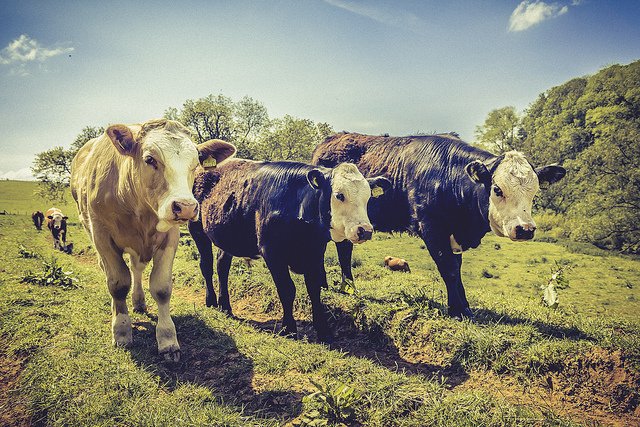

,Идентификатор вопроса,Вопрос,Ответ левой,Ответ правой,Реальный ответ
2430,3480004,Are these steer in a pasture?,no,yes,[yes]
2431,3480005,How many cows are laying down?,2,1,"[0, 1]"


Button(description='Стоп', style=ButtonStyle())

In [8]:
class WIDGETS():
    def __init__(self):
        self.init_widgets()

    def init_widgets(self, error=False):
        clear_output()
        if error:
            myLabel= widgets.HTML(value = f"<b><font color='red'>{error}</b>")
            display(myLabel)

        text = widgets.Label(value="Путь к папке с изображениями:")
        fc = FileChooser()

        select1 = widgets.Select(
            options=['CASCADE', 'CASCADE+BERT', 'CASCADE+COUNTER', 'MCAN', 'MCAN+BERT',
                     'MCAN+ROBERTA', 'MCAN+ALBERT', 'PANOPTIC'],
            value='MCAN',
            # rows=10,
            description='Базовая модель:',
            disabled=False
        )
        select2 = widgets.Select(
            options=['CASCADE', 'CASCADE+BERT', 'CASCADE+COUNTER', 'MCAN', 'MCAN+BERT',
                     'MCAN+ROBERTA', 'MCAN+ALBERT', 'PANOPTIC'],
            value='MCAN',
            # rows=10,
            description='Для сравнения:',
            disabled=False
        )

        submit_button = widgets.Button(description="Начать!")


        display(text)
        display(fc)
        display(widgets.HBox([select1, select2]))

        display(submit_button)

        submit_button.on_click(lambda b: self.on_button_click(
            b, fc.selected_path, select1.value, select2.value
        ))
            
    def on_next_click(self, i):
        clear_output()
        self.iter += i
        if self.iter < 0:
            self.iter = 0
        if self.iter >= self.images.shape[0]:
            self.iter = self.img_path_list - 1
        text = widgets.Label(value=f"Ошибки модели {self.model_base}, но не {self.model_another}")
        display(text)
        text1 = widgets.Label(value=f"Изображение " + str(self.iter + 1) + '/' + str(self.images.shape[0]))
        display(text1)

        text2 = widgets.Label(value=f"Название изображения {self.img_idx_to_path[self.images[self.iter]].split('/')[-1]}")
        display(text2)
        image = Image.open(self.img_idx_to_path[self.images[self.iter]])
        im_idx = self.images[self.iter]
        ques_idx_list = self.df_mcan[self.df_mcan['ImageID'] == im_idx]['QuestionID']
        ques_list = ques_idx_list.apply(lambda x: self.idx_to_ques[int(x)]['question']).values
        model_ans_list = self.df_mcan[self.df_mcan['ImageID'] == im_idx][self.model_base].values
        
        model_mod_ans_list = []
        for q in ques_idx_list:
            model_mod_ans_list.append(self.data[self.data['QuestionID'] == q][self.model_another].values[0])

        real_ans_list = ques_idx_list.apply(lambda x: self.idx_to_ans_list[int(x)]).values
        df = pd.DataFrame({
          "Идентификатор вопроса": ques_idx_list,
          "Вопрос": ques_list,
          "Ответ левой": model_ans_list,
          "Ответ правой": model_mod_ans_list,
          "Реальный ответ": real_ans_list

        })
        display(image)
        display(HTML(df.to_html()))
        next_button = widgets.Button(description="Вперед")
        prev_button = widgets.Button(description="Назад")
        stop_button = widgets.Button(description="Стоп")
        
        display(widgets.HBox([prev_button, next_button]))
        display(stop_button)
        next_button.on_click(lambda b: self.on_next_click(
            1
        ))
        prev_button.on_click(lambda b: self.on_next_click(
            -1
            
        ))
        stop_button.on_click(lambda b: self.init_widgets())

    def on_button_click(self, b, images_path, select_base, select_another):
        clear_output()
        if images_path is None:
            self.init_widgets(error='Выберете папку с изображениями')
            return
        if select_base == select_another:
            self.init_widgets(error='Выбранные модели совпадают')
            return
        text = widgets.Label(value=f"Сравнение модели {select_base} с моделью {select_another}")
        text1 = widgets.Label(value=f"Загрузка файлов...")
        display(text)
        display(text1)
        self.img_path_list = []
        for entry in os.listdir(images_path):
            if os.path.isfile(os.path.join(images_path, entry)):
                self.img_path_list.append(os.path.join(images_path, entry))
        self.path = os.getcwd()
        self.answers_path = os.path.join(self.path, 'annotations.json')
        self.questions_path = os.path.join(self.path, 'question.json')
        self.data_path = os.path.join(self.path, 'concat.csv')
        self.data = pd.read_csv(self.data_path)

        with open(self.answers_path, 'r') as f:
            self.answers = json.load(f)
        with open(self.questions_path, 'r') as f:
            self.questions = json.load(f)
        self.iter = 0
        self.model_base = select_base
        self.model_another = select_another

        self.idx_to_ques = {}
        for ques in self.questions['questions']:
            self.idx_to_ques[int(ques['question_id'])] = ques
        with open('idx_to_ans_list.pkl', 'rb') as f:
            self.idx_to_ans_list = pickle.load(f)
        self.img_idx_to_path = {}
        for img_pth in self.img_path_list:
            self.img_idx_to_path[int(img_pth.split('/')[-1].split('.')[0].split('_')[-1])] = img_pth
        self.df_mcan = pd.read_csv(self.model_base + '.csv') #
        self.df_mod = pd.read_csv(self.model_another + '.csv') #
        s = set(self.df_mcan['QuestionID']) - (set(self.df_mcan['QuestionID']) & set(self.df_mod['QuestionID']))
        self.df_mcan = self.df_mcan[self.df_mcan['QuestionID'].apply(lambda x: x in s)].reset_index()
        self.images = np.unique(self.df_mcan['ImageID'])
        self.on_next_click(0)
a = WIDGETS()

In [20]:
d = {'0' : 'Текст',
     '1' : 'Язык',
     '2' : 'Классификатор',
     '3' : 'Число',
     '4' : 'Частично',
     '5' : 'Неоднозначность',
     '6' : 'Ошибка',}

In [21]:
import json

with open('stat_MCAN.json') as f:
    stat = json.load(f)

In [22]:
stat['iter']

1000

In [26]:
s = 0
for i in range(7):
    print(d[str(i)], stat[str(i)] / stat['iter'] * 100, '%')

Текст 12.6 %
Язык 4.5 %
Классификатор 4.8 %
Число 15.6 %
Частично 4.9 %
Неоднозначность 8.4 %
Ошибка 49.2 %


In [29]:
import json

with open('stat_MCAN+ALBERT.json') as f:
    stat = json.load(f)

In [30]:
s = 0
for i in range(7):
    print(d[str(i)], stat[str(i)] / stat['iter'] * 100, '%')

Текст 13.4 %
Язык 4.8 %
Классификатор 4.3 %
Число 17.299999999999997 %
Частично 5.1 %
Неоднозначность 5.3 %
Ошибка 49.8 %


In [13]:
d = {'QuestionID' : [], 'BAN' : []}
with open('baseline_pred_dump.txt', 'r') as f:
    line = f.readline()
    while line:
        QuestionID = line.split()[0]
        BAN = ' '.join(line.split()[1:])
        d['QuestionID'].append(int(QuestionID))
        d['BAN'].append(BAN)
        line = f.readline()

In [15]:
import pandas as pd
df = pd.DataFrame(d)

In [17]:
df.to_csv('concat1.csv')

In [ ]:
pd.read_csv()

Label(value='Модель: BAN')

Label(value='Изображение 10/1000')

Label(value='Название изображения COCO_val2014_000000084929.jpg')

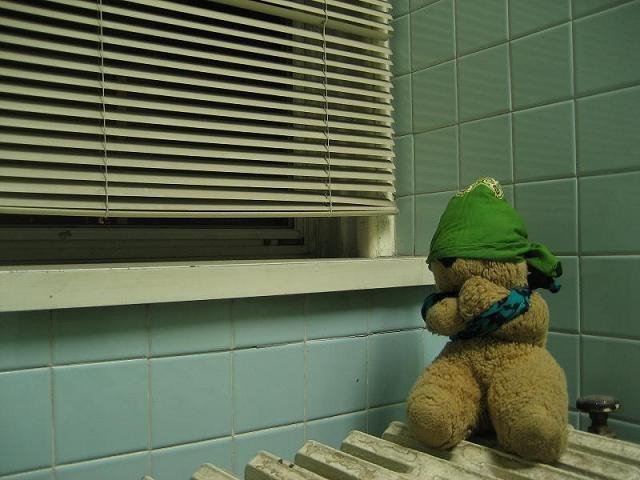

,Идентификатор вопроса,Вопрос,Ответ модели,Реальный ответ
2274,84929000,Why is the teddy bear there?,decoration,"[abandoned, because, he was forgotten, he's hostage, hostage, humor, left there, posed, someone left it, staying warm]"
11014,84929002,What is the bear resting on?,table,"[furnace, heater, radiator, wood]"


In [23]:
class WIDGETS():
    def __init__(self):
        self.init_widgets()

    def init_widgets(self, error=False):
        clear_output()
        if error:
            myLabel= widgets.HTML(value = f"<b><font color='red'>{error}</b>")
            display(myLabel)

        text = widgets.Label(value="Путь к папке с изображениями:")
        fc = FileChooser()

        select = widgets.Select(
            options=['BAN'],
            value='BAN',
            # rows=10,
            description='Модель:',
            disabled=False
        )

        submit_button = widgets.Button(description="Начать!")


        display(text)
        display(fc)
        display(select)

        display(submit_button)

        submit_button.on_click(lambda b: self.on_button_click(
            b, fc.selected_path, select.value
        ))

    def on_next_click(self, i):
        clear_output()
        self.iter += i
        if self.iter < 0:
            self.iter = 0
        if self.iter >= self.images.shape[0]:
            self.iter = self.img_path_list - 1
        text = widgets.Label(value=f"Модель: {self.model}")
        display(text)
        text1 = widgets.Label(value=f"Изображение " + str(self.iter + 1) + '/' + str(self.images.shape[0]))
        display(text1)

        text2 = widgets.Label(value=f"Название изображения {self.img_idx_to_path[self.images[self.iter]].split('/')[-1]}")
        display(text2)
        image = Image.open(self.img_idx_to_path[self.images[self.iter]])
        image = image.resize((int(image.size[0] * 480 / image.size[1]), 480))
        im_idx = self.images[self.iter]
        ques_idx_list = self.df_mcan[self.df_mcan['ImageID'] == im_idx]['QuestionID']
        ques_list = ques_idx_list.apply(lambda x: self.idx_to_ques[int(x)]['question']).values
        model_ans_list = self.df_mcan[self.df_mcan['ImageID'] == im_idx][self.model].values
        real_ans_list = ques_idx_list.apply(lambda x: self.idx_to_ans_list[int(x)]).values
        df = pd.DataFrame({
          "Идентификатор вопроса": ques_idx_list,
          "Вопрос": ques_list,
          "Ответ модели": model_ans_list,
          "Реальный ответ": real_ans_list

        })
        display(image)
        display(HTML(df.to_html()))
                             

        button_text = widgets.Button(description=f"Текст ({self.stat['0']})")
        button_lang = widgets.Button(description=f"Язык ({self.stat['1']})")
        button_class = widgets.Button(description=f"Классификатор ({self.stat['2']})")
        button_number = widgets.Button(description=f"Число ({self.stat['3']})")
        button_partly = widgets.Button(description=f"Частично ({self.stat['4']})")
        button_misund = widgets.Button(description=f"Неоднозначность ({self.stat['5']})")
        button_error = widgets.Button(description=f"Ошибка ({self.stat['6']})")

        display(widgets.HBox([button_text, button_lang, button_class, button_number
                             , button_partly, button_misund, button_error]))

        button_text.on_click(lambda b: self.classify(0))
        button_lang.on_click(lambda b: self.classify(1))
        button_class.on_click(lambda b: self.classify(2))
        button_number.on_click(lambda b: self.classify(3))
        button_partly.on_click(lambda b: self.classify(4))
        button_misund.on_click(lambda b: self.classify(5))
        button_error.on_click(lambda b: self.classify(6))

        next_button = widgets.Button(description="Вперед")
        prev_button = widgets.Button(description="Назад")
        stop_button = widgets.Button(description="Стоп")
        
        display(widgets.HBox([prev_button, next_button]))
        

        display(stop_button)
        next_button.on_click(lambda b: self.on_next_click(
            1
        ))
        prev_button.on_click(lambda b: self.on_next_click(
            -1
            
        ))
        stop_button.on_click(lambda b: self.init_widgets())
    def classify(self, cls):
        self.stat[str(cls)] += 1
        self.stat['iter'] = self.iter + 1
        with open('stat_' + self.model + '.json', 'w') as f:
            json.dump(self.stat, f)     
        self.on_next_click(1)

    def on_button_click(self, b, images_path, select):
        clear_output()
        if images_path is None:
            self.init_widgets(error='Выберете папку с изображениями')
            return
        text = widgets.Label(value=f"Модель: {select}")
        text1 = widgets.Label(value=f"Загрузка файлов...")
        display(text)
        display(text1)
        self.img_path_list = []
        for entry in os.listdir(images_path):
            if os.path.isfile(os.path.join(images_path, entry)):
                self.img_path_list.append(os.path.join(images_path, entry))
        self.path = os.getcwd()
        self.answers_path = os.path.join(self.path, 'annotations.json')
        self.questions_path = os.path.join(self.path, 'question.json')
        with open(self.answers_path, 'r') as f:
            self.answers = json.load(f)
        with open(self.questions_path, 'r') as f:
            self.questions = json.load(f)

        self.iter = 0
        self.model = select
        self.idx_to_ques = {}
        for ques in self.questions['questions']:
            self.idx_to_ques[int(ques['question_id'])] = ques
        import pickle
        with open('idx_to_ans_list.pkl', 'rb') as f:
            self.idx_to_ans_list = pickle.load(f)
        self.img_idx_to_path = {}
        for img_pth in self.img_path_list:
            self.img_idx_to_path[int(img_pth.split('/')[-1].split('.')[0].split('_')[-1])] = img_pth
        ###
        self.df_mcan = pd.read_csv(self.model + '.csv')
        if not os.path.exists('subset1000_' + self.model + '.npy'):
            self.images = np.unique(self.df_mcan['ImageID'])
            self.images = np.random.choice(self.images, 1000, False)
            with open('stat_' + self.model + '.json', 'w') as f:
                stat = {'iter' : 0, '0' : 0, '1' : 0, '2' : 0, '3' : 0, '4' : 0, '5' : 0, '6' : 0}
                json.dump(stat, f)     
            np.save('subset1000_' + self.model + '.npy', self.images)
        self.images = np.load('subset1000_' + self.model + '.npy')
        with open('stat_' + self.model + '.json') as f:
            self.stat = json.load(f)
        self.iter = self.stat['iter']
        self.on_next_click(0)
        ###
        '''
        self.data_path = os.path.join(self.path, 'concat.csv')   
        self.data = pd.read_csv(self.data_path)
        self.iter = 0
        self.model = select
        self.idx_to_ques = {}
        for ques in self.questions['questions']:
            self.idx_to_ques[int(ques['question_id'])] = ques
        self.df_mcan = self.data[self.data['QuestionID'].apply(
            lambda x: np.all(
                self.idx_to_ans_list[int(x)] != self.data[self.data['QuestionID'] == x][self.model].values[0]
            )
        )]
        stay = ['QuestionID', 'ImageID']
        stay.append(self.model)
        self.df_mcan = self.df_mcan.reset_index()
        for col in self.df_mcan.columns:
            if not (col in stay):
                self.df_mcan.drop([col], inplace=True, axis=1)
        self.df_mcan['ImageID'] = self.df_mcan['QuestionID'].apply(lambda x: self.idx_to_ques[int(x)]['image_id'])
        self.df_mcan.to_csv(self.model+ '.csv', index=False)
        self.imgs_pth = np.unique(self.df_mcan['ImageID'])
        text2 = widgets.Label(value=str(self.imgs_pth.shape[0]))
        display(text2)
        '''
a = WIDGETS()